# 신생아 이름

In [1]:
import pandas as pd

In [2]:
names = pd.read_csv('data/pydata-book/names/yob1880.txt', names=['name', 'gender', 'count'])
names[:5]

,name,gender,count
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746


모든 파일을 데이터프레임으로 읽어오기
 * 경로만 잘 구성해 주면 됨

In [3]:
프레임목록 = []
for 연도 in range(1880, 2011):
    경로 = 'data/pydata-book/names/yob{}.txt'.format(연도)
    프레임 = pd.read_csv(경로, names=['이름', '성별', '출생수'])
    프레임['연도'] = 연도
    프레임목록.append(프레임)

In [4]:
프레임목록[0][:3]

,이름,성별,출생수,연도
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880


In [5]:
names = pd.concat(프레임목록, ignore_index=True)
len(names)

1690784

In [6]:
%matplotlib inline

In [7]:
total_births = names.pivot_table('출생수', aggfunc='sum', index='연도', columns='성별')

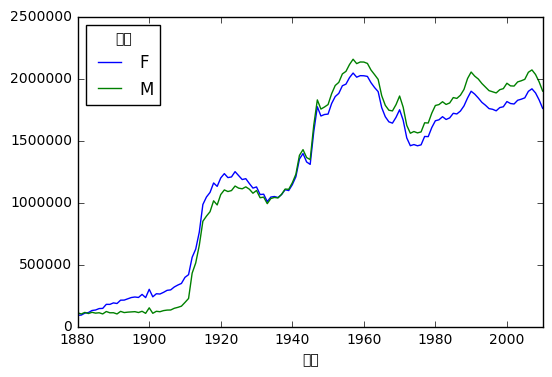

In [8]:
total_births.plot()

연도별 성별 분류별 각 이름의 비율 산출

In [9]:
def 비율산출(프레임):
    프레임['비율'] = 프레임['출생수'] / 프레임['출생수'].sum()
    return 프레임

In [10]:
names = names.groupby(['연도', '성별']).apply(비율산출)

In [11]:
def get_top1000(프레임):
    return 프레임.sort_values(by='출생수', ascending=False)[:1000]

In [12]:
연도별성별 = names.groupby(['연도', '성별'])

In [13]:
top1000 = 연도별성별.apply(get_top1000)

In [14]:
top1000[:20]

이름 성별   출생수    연도        비율
연도   성별                                       
1880 F  0        Mary  F  7065  1880  0.077643
        1        Anna  F  2604  1880  0.028618
        2        Emma  F  2003  1880  0.022013
        3   Elizabeth  F  1939  1880  0.021309
        4      Minnie  F  1746  1880  0.019188
        5    Margaret  F  1578  1880  0.017342
        6         Ida  F  1472  1880  0.016177
        7       Alice  F  1414  1880  0.015540
        8      Bertha  F  1320  1880  0.014507
        9       Sarah  F  1288  1880  0.014155
        10      Annie  F  1258  1880  0.013825
        11      Clara  F  1226  1880  0.013474
        12       Ella  F  1156  1880  0.012704
        13   Florence  F  1063  1880  0.011682
        14       Cora  F  1045  1880  0.011484
        15     Martha  F  1040  1880  0.011429
        16      Laura  F  1012  1880  0.011122
        17     Nellie  F   995  1880  0.010935
        18      Grace  F   982  1880  0.010792
        19     Carrie  F   949  1880  0.010429

## 이름 유행 분석
연도별 이름별 출생수 합계

In [15]:
total_births = top1000.pivot_table('출생수', aggfunc='sum', index='연도', columns='이름')

남녀 대표 이름 두 개씩 선택

In [16]:
대표이름 = ['John', 'Harry', 'Mary', 'Marilyn']

In [17]:
subset = total_births[대표이름]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000017696FD0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000001767D6A0>], dtype=object)

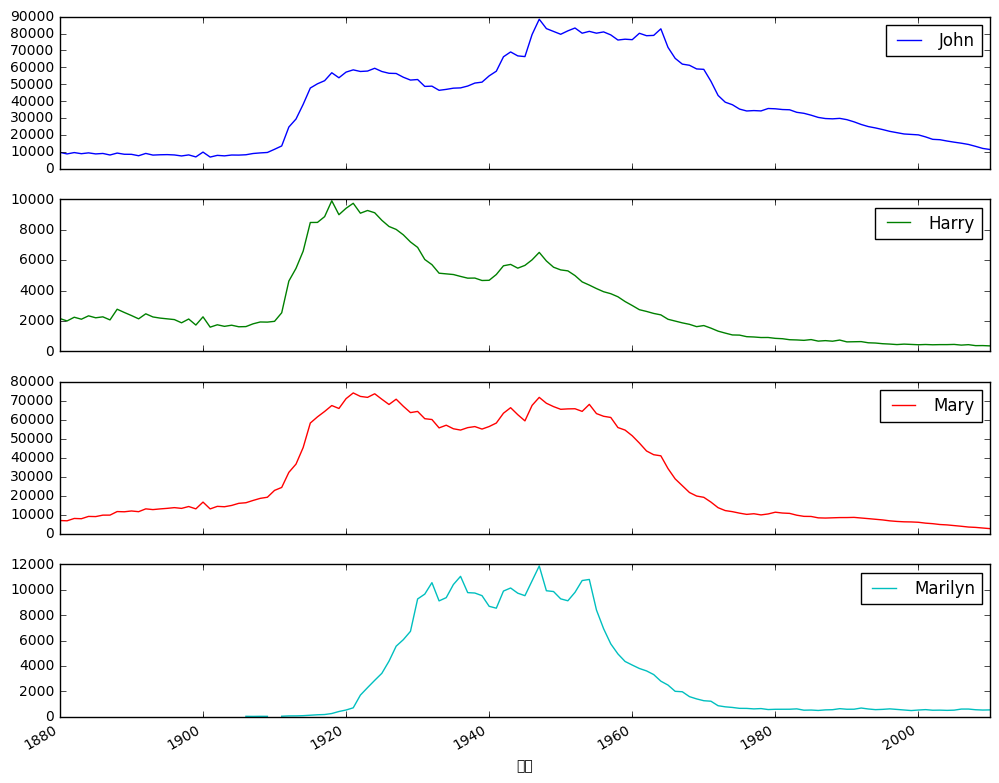

In [18]:
subset.plot(subplots=True, figsize=(12,10))

### 다양한 이름을 사용하는 경향 파악하기
가설: "사람들은 자녀에게 개성있는 이름을 주고 싶어한다"

입증방법1: 각 그룹의 상위 1000개 이름이 전체 이름에서 차지하는 비율이 시간의 흐름에 따라 감소한다면, 더 많은 종류의 이름이 사용된다고 할 수 있다.

In [19]:
연도별성별_비율합계 = top1000.pivot_table('비율', aggfunc='sum', index='연도', columns='성별')

In [20]:
연도별성별_비율합계[-5:]

성별,F,M
연도,,
2006,0.753153,0.860368
2007,0.745959,0.855159
2008,0.740933,0.850003
2009,0.737290,0.845256
2010,0.736780,0.843156


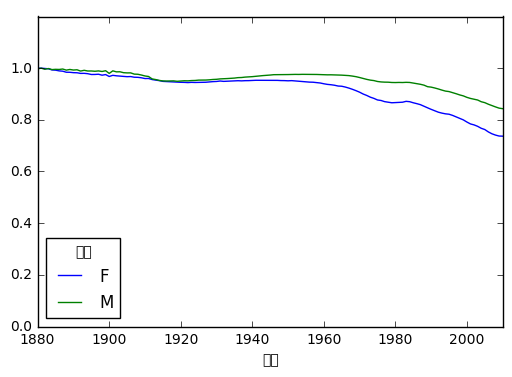

In [21]:
연도별성별_비율합계.plot(ylim=(0.0, 1.2))

입증방법2: 전체의 절반을 차지하는 이름들의 개수가 증가한다면, 보다 다양한 이름이 사용된다고 할 수 있다.

1. 비율의 내림차순 정렬
1. 누적 합계 산출
1. 누적합계 0.5 이상까지 이름 개수 집계

In [22]:
남아인가 = names['성별'] == 'M'
남아 = names[남아인가]

In [23]:
남아2010 = 남아[남아.연도 == 2010]
남아2010[:3]

,이름,성별,출생수,연도,비율
1676644,Jacob,M,21875,2010,0.011523
1676645,Ethan,M,17866,2010,0.009411
1676646,Michael,M,17133,2010,0.009025


In [24]:
누적비율합계 = 남아2010.sort_values(by='비율', ascending=False).비율.cumsum()

In [25]:
누적비율합계[:5]

1676644    0.011523
1676645    0.020934
1676646    0.029959
1676647    0.038930
1676648    0.047817
Name: 비율, dtype: float64

In [26]:
len(누적비율합계[누적비율합계 <= 0.5])

116

한 개의 프레임에 적용할 논리가 완성되면, 각 그룹에 적용할 함수를 제작합니다.

In [27]:
def 백분위개수산출(프레임, q=0.5):
    누적비율 = 프레임.sort_values(by='비율', ascending=False).비율.cumsum()
    return len(누적비율[누적비율<=0.5]) + 1

In [28]:
diversity = 연도별성별.apply(백분위개수산출)

In [29]:
diversity = diversity.unstack('성별')

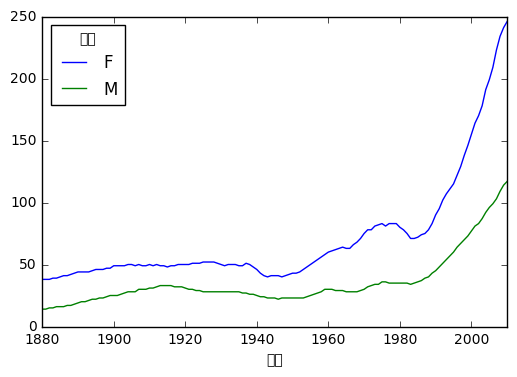

In [30]:
diversity.plot()

### 마지막 글자 유행

각 이름에서 마지막 글자 추출

In [31]:
last_letters = names.이름.str[-1]
last_letters.name = '말자'

In [32]:
last_letters[:5]

0    y
1    a
2    a
3    h
4    e
Name: 말자, dtype: object

말자별 성별 연도별 출생수 합계

In [33]:
table = names.pivot_table('출생수', aggfunc='sum', index=last_letters, columns=['성별', '연도'])

In [34]:
table[:5]

성별        F                                                                 \
연도     1880     1881     1882     1883     1884     1885     1886     1887   
말자                                                                           
a   31446.0  31581.0  36536.0  38330.0  43680.0  45408.0  49100.0  48942.0   
b       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
c       NaN      NaN      5.0      5.0      NaN      NaN      NaN      NaN   
d     609.0    607.0    734.0    810.0    916.0    862.0   1007.0   1027.0   
e   33378.0  34080.0  40399.0  41914.0  48089.0  49616.0  53884.0  54353.0   

성별                      ...            M                                \
연도     1888     1889    ...         2001      2002      2003      2004   
말자                      ...                                              
a   59442.0  58631.0    ...      39124.0   38815.0   37825.0   38650.0   
b       NaN      NaN    ...      50950.0   49284.0   48065.0   45914.0   
c       NaN      NaN    ...      27113.0   27238.0   27697.0   26778.0   
d    1298.0   1374.0    ...      60838.0   55829.0   53391.0   51754.0   
e   66750.0  66663.0    ...     145395.0  144651.0  144769.0  142098.0   

성별                                                              
연도      2005      2006      2007      2008      2009      2010  
말자                                                              
a    36838.0   36156.0   34654.0   32901.0   31430.0   28438.0  
b    43144.0   42600.0   42123.0   39945.0   38862.0   38859.0  
c    26078.0   26635.0   26864.0   25318.0   24048.0   23125.0  
d    50670.0   51410.0   50595.0   47910.0   46172.0   44398.0  
e   141123.0  142999.0  143698.0  140966.0  135496.0  129012.0  

[5 rows x 262 columns]

In [35]:
subtable = table.reindex(columns=[1910, 1960, 2010], level='연도')

In [36]:
subtable[:5]

성별         F                            M                    
연도      1910      1960      2010     1910      1960      2010
말자                                                           
a   108376.0  691247.0  670605.0    977.0    5204.0   28438.0
b        NaN     694.0     450.0    411.0    3912.0   38859.0
c        5.0      49.0     946.0    482.0   15476.0   23125.0
d     6750.0    3729.0    2607.0  22111.0  262112.0   44398.0
e   133569.0  435013.0  313833.0  28655.0  178823.0  129012.0

In [37]:
합계 = subtable.sum()

In [38]:
말자비율 = subtable / 합계

In [39]:
말자비율[:5]

성별         F                             M                    
연도      1910      1960      2010      1910      1960      2010
말자                                                            
a   0.273390  0.341853  0.381240  0.005031  0.002440  0.014980
b        NaN  0.000343  0.000256  0.002116  0.001834  0.020470
c   0.000013  0.000024  0.000538  0.002482  0.007257  0.012181
d   0.017028  0.001844  0.001482  0.113858  0.122908  0.023387
e   0.336941  0.215133  0.178415  0.147556  0.083853  0.067959

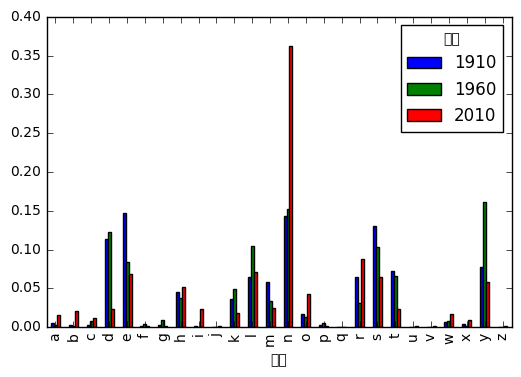

In [40]:
말자비율['M'].plot(kind='bar')

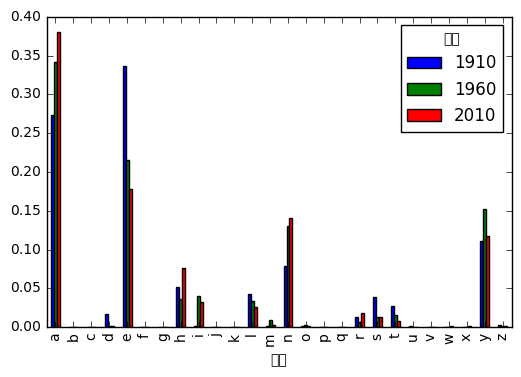

In [41]:
말자비율['F'].plot(kind='bar')

전체 연도에 대해 말자별 비율 산출

In [42]:
말자비율 = table / table.sum()

In [43]:
말자비율[:5]

성별         F                                                              \
연도      1880      1881      1882      1883      1884      1885      1886   
말자                                                                         
a   0.345587  0.343440  0.338764  0.341251  0.338550  0.341270  0.339703   
b        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
c        NaN       NaN  0.000046  0.000045       NaN       NaN       NaN   
d   0.006693  0.006601  0.006806  0.007211  0.007100  0.006478  0.006967   
e   0.366819  0.370616  0.374582  0.373159  0.372722  0.372896  0.372802   

성별                                  ...            M                      \
연도      1887      1888      1889    ...         2001      2002      2003   
말자                                  ...                                    
a   0.335258  0.332764  0.328706    ...     0.020162  0.020019  0.019177   
b        NaN       NaN       NaN    ...     0.026256  0.025418  0.024368   
c        NaN       NaN       NaN    ...     0.013972  0.014048  0.014042   
d   0.007035  0.007266  0.007703    ...     0.031352  0.028794  0.027069   
e   0.372324  0.373675  0.373736    ...     0.074927  0.074603  0.073396   

성별                                                                        
연도      2004      2005      2006      2007      2008      2009      2010  
말자                                                                        
a   0.019505  0.018481  0.017635  0.016747  0.016189  0.015927  0.014980  
b   0.023171  0.021645  0.020778  0.020357  0.019655  0.019693  0.020470  
c   0.013514  0.013083  0.012991  0.012983  0.012458  0.012186  0.012181  
d   0.026118  0.025420  0.025075  0.024451  0.023574  0.023398  0.023387  
e   0.071710  0.070799  0.069748  0.069445  0.069362  0.068663  0.067959  

[5 rows x 262 columns]

In [44]:
남아dny = 말자비율.ix[['d', 'n', 'y'], 'M']

In [45]:
남아dny = 남아dny.T

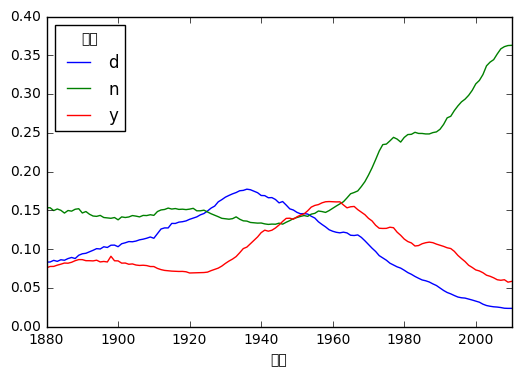

In [46]:
남아dny.plot()

### 남자 이름과 여자 이름이 바뀐 경우

"레슬리" 는 lesl 로 시작함

In [47]:
이름목록 = top1000.이름.drop_duplicates()
이름목록[:5]

연도    성별   
1880  F   0         Mary
          1         Anna
          2         Emma
          3    Elizabeth
          4       Minnie
Name: 이름, dtype: object

In [48]:
lesl = 이름목록.str.lower().str.startswith('lesl')

In [49]:
lesley_like = list(이름목록[lesl])

In [51]:
레슬리니 = top1000.이름.isin(lesley_like)

In [52]:
레슬리 = top1000[레슬리니]

In [53]:
연도별성별_레슬리합계 = 레슬리.pivot_table('출생수', aggfunc='sum', index='연도', columns='성별')

In [54]:
합계 = 연도별성별_레슬리합계.sum(1)
연도별성별_레슬리비율 = 연도별성별_레슬리합계.div(합계, axis=0)

In [55]:
연도별성별_레슬리비율[-5:]

성별,F,M
연도,,
2006,1.0,NaN
2007,1.0,NaN
2008,1.0,NaN
2009,1.0,NaN
2010,1.0,NaN


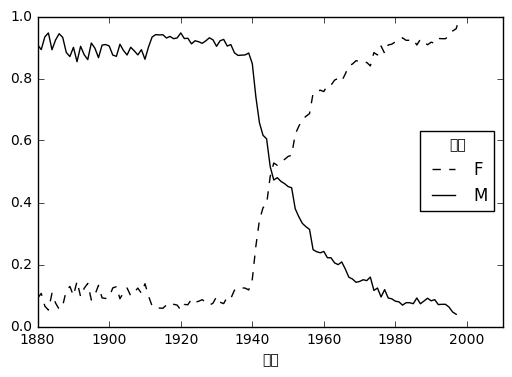

In [61]:
연도별성별_레슬리비율.plot(style={'M':'k-', 'F':'k--'})